<a href="https://colab.research.google.com/github/pinilDissanayaka/Paddy-Doctor-Paddy-Disease-Classification/blob/main/Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install livelossplot
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 10.0 MB/s eta 0:00:00


In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [11]:
! kaggle datasets download ricardosalvatorelli1/paddydoctor

Dataset URL: https://www.kaggle.com/datasets/ricardosalvatorelli1/paddydoctor
License(s): unknown
100% 1.02G/1.02G [00:15<00:00, 89.1MB/s]
100% 1.02G/1.02G [00:15<00:00, 69.3MB/s]


In [13]:
! unzip paddydoctor.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/downy_mildew/100992.jpg  
  inflating: train_images/downy_mildew/100995.jpg  
  inflating: train_images/downy_mildew/101015.jpg  
  inflating: train_images/downy_mildew/101020.jpg  
  inflating: train_images/downy_mildew/101022.jpg  
  inflating: train_images/downy_mildew/101024.jpg  
  inflating: train_images/downy_mildew/101034.jpg  
  inflating: train_images/downy_mildew/101050.jpg  
  inflating: train_images/downy_mildew/101078.jpg  
  inflating: train_images/downy_mildew/101096.jpg  
  inflating: train_images/downy_mildew/101103.jpg  
  inflating: train_images/downy_mildew/101114.jpg  
  inflating: train_images/downy_mildew/101119.jpg  
  inflating: train_images/downy_mildew/101142.jpg  
  inflating: train_images/downy_mildew/101177.jpg  
  inflating: train_images/downy_mildew/101178.jpg  
  inflating: train_images/downy_mildew/101181.jpg  
  inflating: train_images/downy_mildew/101205.jpg  
  inflating: 

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
import os
import random
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKerasTF
import visualkeras
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings(action = 'ignore')

In [14]:
trainDir=f"/content/train_images"
testDir=f"/content/test_images"

In [23]:
trainFolders=glob(os.path.join(trainDir, '*'))
outputSize=len(trainFolders)

print(f'Number of folders: {outputSize}\n')
for folder in trainFolders:
  print(f"class {os.path.basename(folder)}: {len(glob(os.path.join(folder, '*')))}")

Number of folders: 10

class tungro: 1088
class dead_heart: 1442
class hispa: 1594
class bacterial_leaf_blight: 479
class bacterial_leaf_streak: 380
class brown_spot: 965
class normal: 1764
class bacterial_panicle_blight: 337
class downy_mildew: 620
class blast: 1738


In [35]:
def printImages(trainFolders):
  for trainFolder in trainFolders:
    images=random.choices(glob(os.path.join(trainFolder, '*')), k=16)
    print(images)
    plt.figure(figsize = (16, 16))
    for image in enumerate(images):
      image=plt.imread(image)
      plt.imshow(image)

['/content/train_images/tungro/110052.jpg', '/content/train_images/tungro/101978.jpg', '/content/train_images/tungro/100811.jpg', '/content/train_images/tungro/103239.jpg', '/content/train_images/tungro/102989.jpg', '/content/train_images/tungro/102449.jpg', '/content/train_images/tungro/108024.jpg', '/content/train_images/tungro/102901.jpg', '/content/train_images/tungro/106704.jpg', '/content/train_images/tungro/100468.jpg', '/content/train_images/tungro/104145.jpg', '/content/train_images/tungro/109305.jpg', '/content/train_images/tungro/110336.jpg', '/content/train_images/tungro/105094.jpg', '/content/train_images/tungro/108933.jpg', '/content/train_images/tungro/109982.jpg']


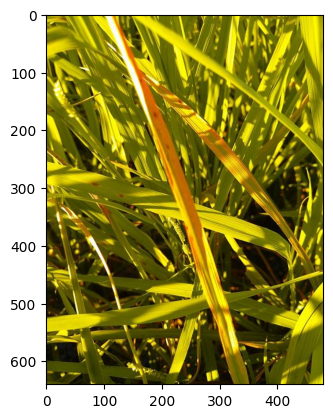

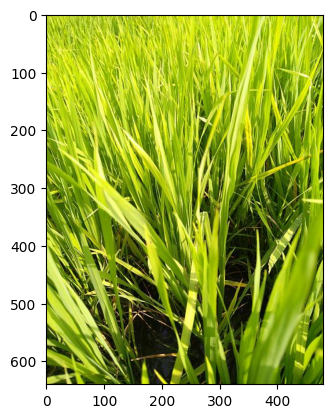

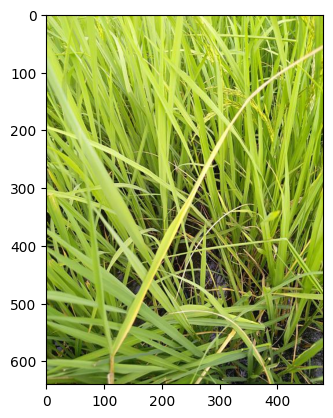

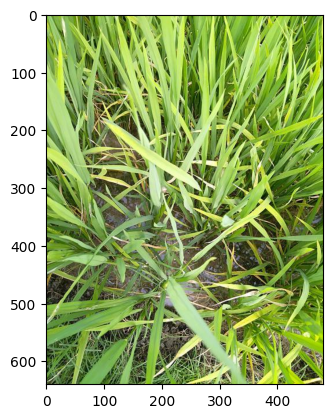

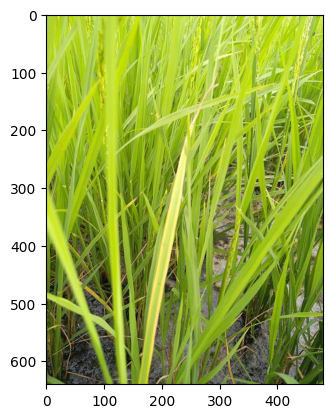

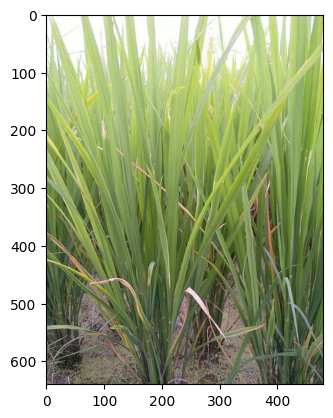

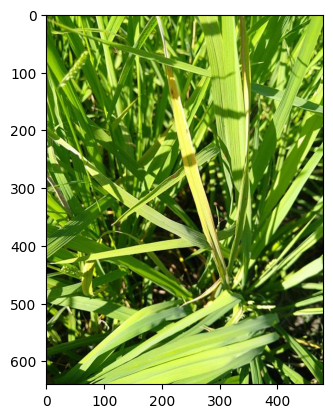

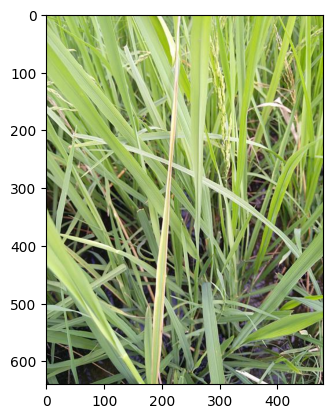

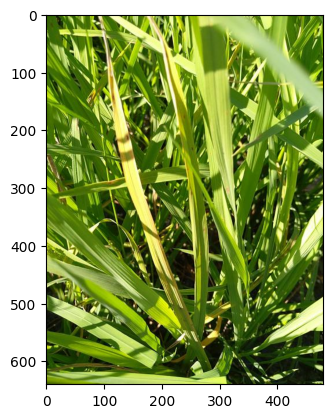

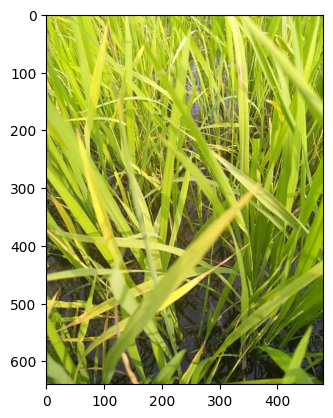

In [ ]:
printImages(trainFolders=trainFolders)

In [26]:
trainFolders

['/content/train_images/tungro',
 '/content/train_images/dead_heart',
 '/content/train_images/hispa',
 '/content/train_images/bacterial_leaf_blight',
 '/content/train_images/bacterial_leaf_streak',
 '/content/train_images/brown_spot',
 '/content/train_images/normal',
 '/content/train_images/bacterial_panicle_blight',
 '/content/train_images/downy_mildew',
 '/content/train_images/blast']